## CORACLE Set-up and Evaluation

In [1]:
### Data Processing

## Ignore warnings
import warnings
warnings.filterwarnings("ignore")
# Helper imports
import numpy as np
import pandas as pd
import os
import sys

from functools import reduce
import matplotlib.pyplot as plt

%matplotlib inline

current_working_dir = os.getcwd()
print(f"Current Working Directory: {current_working_dir}")
project_root = os.path.dirname(current_working_dir)
modules_path = os.path.join(project_root, 'Modules')
if modules_path not in sys.path:
    sys.path.append(modules_path)
    print(f"Added to sys.path for custom modules: {modules_path}")

####################################################################
#### NYSE Daily Open-Close Returns
####################################################################
data_folder_path = os.path.join(project_root, 'Data')
data_file_name = "OPCL_20000103_20201231.csv"   
data_file_path = os.path.join(data_folder_path, data_file_name) # So that we get to the file itself and not the folder it is in
returns_df = pd.read_csv(data_file_path) # Assumes file exists and is readable
returns_df.set_index('ticker', inplace=True)
returns_df.columns = pd.to_datetime(returns_df.columns.str.lstrip('X'), format='%Y%m%d').strftime('%Y-%m-%d')
returns_df_cleaned = returns_df.dropna().transpose() # Assumes dropna results in non-empty returns_df
returns_df_cleaned.index = pd.to_datetime(returns_df_cleaned.index)
returns_df_cleaned.index.name = 'date'
print("Data loaded and cleaned. Sample (first 5 rows/cols):")
print(returns_df_cleaned.iloc[0:5,0:5])
print(f"Shape of the cleaned data: {returns_df_cleaned.shape}")


Current Working Directory: n:\GitHub\ICAIF_25\Current_Code\Script
Added to sys.path for custom modules: n:\GitHub\ICAIF_25\Current_Code\Modules
Data loaded and cleaned. Sample (first 5 rows/cols):
ticker            AA       ABM       ABT       ADI       ADM
date                                                        
2000-01-03 -0.013042 -0.009188 -0.007117 -0.036071  0.000000
2000-01-04  0.010043  0.012346 -0.012786 -0.044261  0.005277
2000-01-05  0.047628 -0.006192  0.011111  0.014493 -0.015915
2000-01-06 -0.011713  0.000000  0.032553 -0.027719  0.010695
2000-01-07 -0.016118  0.003091  0.028573  0.033654  0.005249
Shape of the cleaned data: (5279, 663)


### Confounding Data

In [2]:
####################################################################
#### Constructing the dataframe for the Confounding Variables
####################################################################

"""
Data Source: Federal Reserve Economic Data (FRED)

DFF -> Federal Funds Effective Rate
T5YIE -> 5-Year Breakeven Inflation Rate (only from 2003)
USEPUINDXD -> Economic Policy Uncertainty Index for United States; News-based, 7 days moving average
VIX -> CBOE Volatility Index (VIX)
DCOILWTICO -> West Texas Intermediate (WTI) Crude Oil Prices: Cushing, Oklahoma
DTWEXBGS -> Broad U.S. Dollar Index: Trade Weighted Exchange Rate Index for Major Currencies (only from 2006)
DTWEXEMEGS-> Broad U.S. Dollar Index: Trade Weighted Exchange Rate Index for Emerging Market Economies (only from 2006)

Other Potential Data Sources:
Gold Prices (Futures/Spot), etc.
"""

files = ["DFF_20000103_20201231.csv",
         "T5YIE_20030102_20201231.csv",
         "USEPUINDXD_20000103_20201231.csv",
         "VIX_20000103_20201231.csv",
         "DCOILWTICO_20000103_20201231.csv",
         "DTWEXBGS_20060102_20201231.csv",
         "DTWEXEMEGS_20060102_20201231.csv"
         ]


merged_confound_df = reduce(
    lambda left, right: pd.merge(left, right, on="observation_date", how="outer"),
    (pd.read_csv(os.path.join(data_folder_path, f), parse_dates=[0]) for f in files)
)
imputed_confound_df = merged_confound_df.interpolate(method='linear', limit_direction='both')
imputed_confound_df.set_index('observation_date', inplace=True)
imputed_confound_df.index.name = 'date'  # Renaming index to 'date'
print("Confounding Variables DataFrame constructed and cleaned. Sample (first 5 rows/cols):")
print(imputed_confound_df.iloc[0:5,:])
print(f"Shape of the cleaned confounding variables data: {imputed_confound_df.shape}")
filtered_confound_df = imputed_confound_df[imputed_confound_df.index.isin(returns_df_cleaned.index)]
print("\n")
print("Filtering by trading dates ...")
print("\n")
print("Filtered Confounding Variables DataFrame:")
print(filtered_confound_df.head())
print(f"Shape of the filtered confounding variables data: {filtered_confound_df.shape}")

Confounding Variables DataFrame constructed and cleaned. Sample (first 5 rows/cols):
             DFF  T5YIE  USEPUINDXD  VIXCLS  DCOILWTICO  DTWEXBGS  DTWEXEMEGS
date                                                                         
2000-01-01  3.99    1.3       68.04   24.21       25.56  101.4155    100.9386
2000-01-02  3.99    1.3      119.36   24.21       25.56  101.4155    100.9386
2000-01-03  5.43    1.3       35.73   24.21       25.56  101.4155    100.9386
2000-01-04  5.38    1.3      109.31   27.01       25.56  101.4155    100.9386
2000-01-05  5.41    1.3      123.22   26.41       24.65  101.4155    100.9386
Shape of the cleaned confounding variables data: (7671, 7)


Filtering by trading dates ...


Filtered Confounding Variables DataFrame:
             DFF  T5YIE  USEPUINDXD  VIXCLS  DCOILWTICO  DTWEXBGS  DTWEXEMEGS
date                                                                         
2000-01-03  5.43    1.3       35.73   24.21       25.56  101.4155    100.9386

## ORACLE-VAR

In [3]:
from DML_tools import *

returns_df_cleaned_prep = returns_df_cleaned.iloc[-1300:,:20]
# returns_df_cleaned_prep = returns_df_cleaned.iloc[-1050:,:20]
filtered_confound_df_prep = filtered_confound_df.loc[returns_df_cleaned_prep.index]
print(filtered_confound_df_prep.head())
print(filtered_confound_df_prep.shape)

             DFF  T5YIE  USEPUINDXD  VIXCLS  DCOILWTICO  DTWEXBGS  DTWEXEMEGS
date                                                                         
2015-11-02  0.12   1.23       32.86   14.15       46.12  110.2188    112.4965
2015-11-03  0.12   1.27       72.75   14.54       47.88  110.2440    112.1118
2015-11-04  0.12   1.26       45.24   15.51       46.32  110.7139    112.5096
2015-11-05  0.12   1.23       33.09   15.05       45.27  110.8302    112.6224
2015-11-06  0.12   1.25       78.78   14.33       44.32  111.7603    113.2503
(1300, 7)


In [4]:
# rolling_window_OR_VAR_w_para_search(asset_df = returns_df_cleaned_prep, confound_df = filtered_confound_df_prep,
#                                               days_valid = 2)

In [ ]:
results = parallel_rolling_window_OR_VAR_w_para_search(asset_df = returns_df_cleaned_prep, confound_df = filtered_confound_df_prep,
                                                       days_valid=2, max_threads=3)

Start time: 2025-06-27 03:32:15
Beginning search for optimal VAR order for each day


In [22]:
import pickle

# Save the dictionary
#with open('result.pkl', 'wb') as f:
#    pickle.dump(results, f)

# Load the dictionary
with open('result.pkl', 'rb') as f:
    results = pickle.load(f)

In [ ]:
import pickle

# Save the dictionary
with open('result_2.pkl', 'wb') as f:
    pickle.dump(results, f)

# Load the dictionary
with open('result_2.pkl', 'rb') as f:
    results = pickle.load(f)

In [6]:
## Using results, we will plot the overall PnL

# First, we compute the PnL for each day.
print(results)

{'test_start': 1008, 'num_days': 1099, 'p_optimal': array([1., 1., 3., 3., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 3., 3., 1., 1., 1., 1., 1., 2., 2., 1., 1., 1., 1., 1., 1., 1.,
       1., 3., 3., 3., 1., 1., 1., 2., 1., 1., 2., 1., 1., 1., 3., 3., 1.,
       2., 1., 1., 3., 3., 3., 1., 1., 1., 1., 1., 3., 2., 2., 1., 1., 3.,
       3., 1., 1., 3., 3., 3., 3., 2., 2., 2., 2., 3., 1., 3., 1., 1., 1.,
       1., 1., 1., 1., 1., 1.]), 'Y_hat_next_store': array([[ 0.01,  0.  , -0.  , ..., -0.  , -0.01, -0.  ],
       [ 0.01, -0.  , -0.  , ..., -0.01, -0.  , -0.  ],
       [ 0.03,  0.02,  0.01, ...,  0.01,  0.01,  0.01],
       ...,
       [-0.  ,  0.  ,  0.01, ..., -0.  ,  0.  , -0.  ],
       [ 0.  ,  0.  , -0.  , ..., -0.  , -0.01,  0.  ],
       [ 0.01, -0.  ,  0.  , ...,  0.  , -0.  ,  0.01]])}


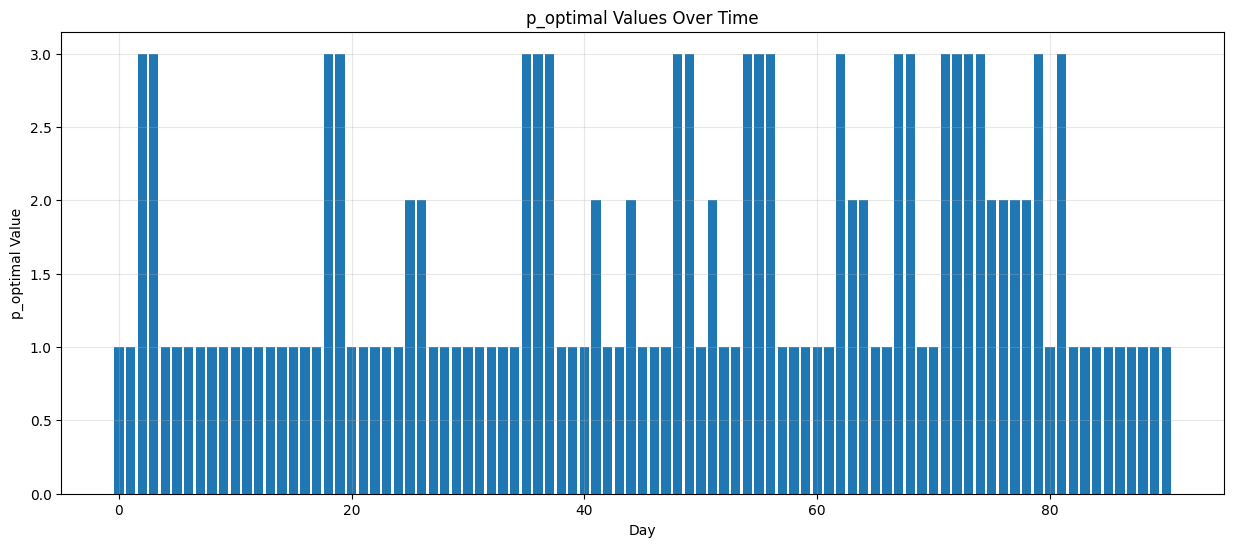

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Extract p_optimal from your results dictionary
p_optimal = results['p_optimal']
days = np.arange(len(p_optimal))

# Create the plot
plt.figure(figsize=(15, 6))
plt.bar(days, p_optimal)
plt.xlabel('Day')
plt.ylabel('p_optimal Value')
plt.title('p_optimal Values Over Time')
plt.grid(True, alpha=0.3)
plt.show()

In [24]:
print(len(results["p_optimal"]))
print(len(returns_df_cleaned_prep))
print(len(returns_df_cleaned_prep.index[-1100+252*4+1:]))

91
1050
91


In [ ]:
from DML_tools import calculate_pnl
forecasted_returns = pd.DataFrame(results['Y_hat_next_store'],
                                  index=returns_df_cleaned_prep.index[-1300+252*4+1:], 
                                  # index=returns_df_cleaned_prep.index[-1100+252*4+1:], 
                                  columns=returns_df_cleaned_prep.columns)
actual_returns = returns_df_cleaned_prep.iloc[-1300+252*4+1:,:20]
# actual_returns = returns_df_cleaned_prep.iloc[-1050+252*4+1:,:20]
print(forecasted_returns.shape)
print(actual_returns.shape)

pnl_series_n, pnl_per_n = calculate_pnl(forecasted_returns, actual_returns, contrarian = True, pnl_strategy="naive")
pnl_series_w, pnl_per_w = calculate_pnl(forecasted_returns, actual_returns, contrarian = True, pnl_strategy="weighted")
pnl_series_t, pnl_per_t = calculate_pnl(forecasted_returns, actual_returns, contrarian = True, pnl_strategy="top")

'''
Example
forecasted_returns = [[3,4],
                      [2,1],
                      [5,6]]
Each column is an asset, and each row is a day (prediction for next three days, for 2 assets)

actual_returns     = [[4,4],
                      [5,1],
                      [5,7]]

calculate_pnl returns a a series of PnL values for each day based on the strategy specified;

shape = [[1.04],
         [0.978],
         [1.01]]
    where each value is the PnL for that day based on the strategy (these are cumulative PnL)

'''

(91, 20)
(41, 20)
Daily portfolio returns (percentage change): date
2020-08-24    0.000000
2020-08-25    0.000000
2020-08-26    0.000000
2020-08-27    0.000000
2020-08-28    0.000000
                ...   
2020-12-24    0.001572
2020-12-28    0.003517
2020-12-29    0.002621
2020-12-30    0.000171
2020-12-31    0.000786
Length: 91, dtype: float64
Daily portfolio returns (percentage change): date
2020-08-24    0.000000
2020-08-25    0.000000
2020-08-26    0.000000
2020-08-27    0.000000
2020-08-28    0.000000
                ...   
2020-12-24    0.002674
2020-12-28    0.004830
2020-12-29   -0.000134
2020-12-30    0.000408
2020-12-31    0.000233
Length: 91, dtype: float64
Daily portfolio returns (percentage change): date
2020-08-24    0.000000
2020-08-25    0.000000
2020-08-26    0.000000
2020-08-27    0.000000
2020-08-28    0.000000
                ...   
2020-12-24    0.001922
2020-12-28    0.009800
2020-12-29    0.002605
2020-12-30    0.003896
2020-12-31    0.000000
Length: 91, dtype: 

'\nExample\nforecasted_returns = [[3,4],\n                      [2,1],\n                      [5,6]]\nEach column is an asset, and each row is a day (prediction for next three days, for 2 assets)\n\nactual_returns     = [[4,4],\n                      [5,1],\n                      [5,7]]\n\ncalculate_pnl returns a a series of PnL values for each day based on the strategy specified;\n\nshape = [[1.04],\n         [0.978],\n         [1.01]]\n    where each value is the PnL for that day based on the strategy (these are cumulative PnL)\n\n'

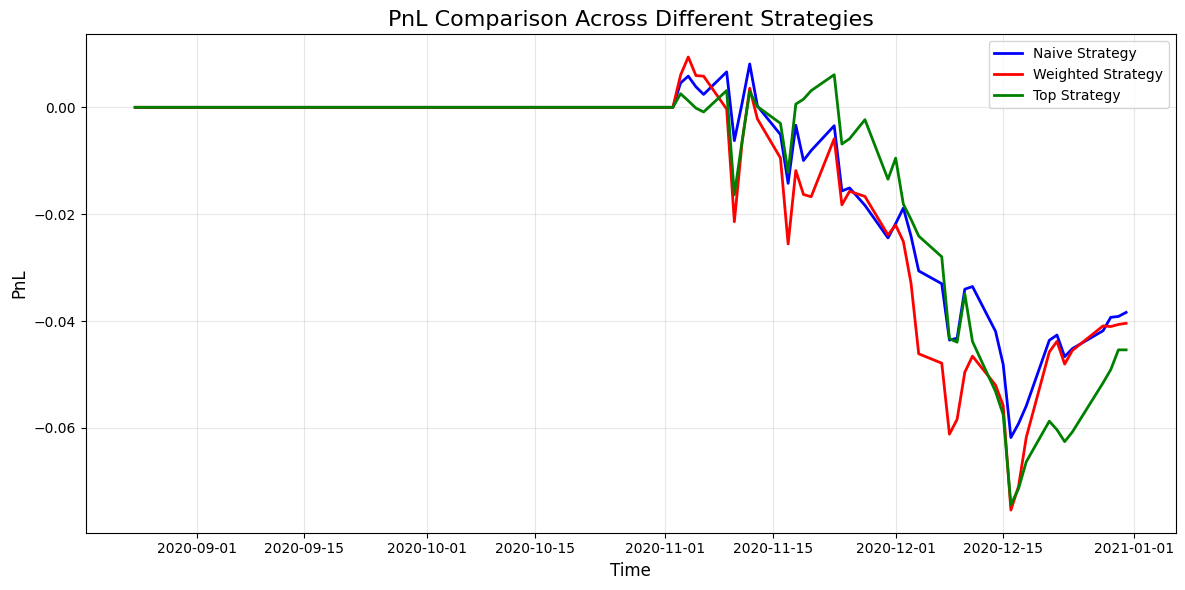

In [26]:
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(pnl_series_n, color='blue', label='Naive Strategy', linewidth=2)
plt.plot(pnl_series_w, color='red', label='Weighted Strategy', linewidth=2)
plt.plot(pnl_series_t, color='green', label='Top Strategy', linewidth=2)

# Customize the plot
plt.title('PnL Comparison Across Different Strategies', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('PnL', fontsize=12)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.savefig('pnl_comparison.png')
plt.show()

In [ ]:
def get_metrics(series, perc):
    # For a compounding PnL series, daily returns are the percentage change.
    daily_rets = perc.dropna()

    # Calculate Compound Annual Growth Rate (CAGR)
    total_return = series.iloc[-1] 
    ann_ret = (1 + total_return) ** (252 / len(series)) - 1

    # Sharpe ratio calculation remains valid with the corrected daily returns.
    # We assume a risk-free rate of 0 for this calculation.
    sharpe = (daily_rets.mean() * 252) / (daily_rets.std() * np.sqrt(252))
    return ann_ret * 100, sharpe

# Get metrics for all strategies
for name, series, perc in [("Naive", pnl_series_n, pnl_per_n), ("Weighted", pnl_series_w, pnl_per_w), ("Top", pnl_series_t, pnl_per_t)]:
    ann_ret, sharpe = get_metrics(series, perc)
    print(f"{name}: {ann_ret:.4f}% annualized, Sharpe: {sharpe:.4f}")

Naive: 34.7338% annualized, Sharpe: 2.1211
Weighted: 62.6912% annualized, Sharpe: 2.4075
Top: 70.9131% annualized, Sharpe: 2.8248
